In [1]:
%pylab inline
import jax
import jax.numpy as np
import tensorflow_probability as tfp; tfp = tfp.experimental.substrates.jax
tfd = tfp.distributions
from nsec.samplers import ScoreHamiltonianMonteCarlo
from nsec.datasets.two_moons import get_two_moons
from nsec.replica_exchange_mc import ReplicaExchangeMC

Populating the interactive namespace from numpy and matplotlib


In [2]:
from functools import partial

def logp(x, sigma):
    return get_two_moons(sigma+0.02).log_prob(x).squeeze()

dlogp = jax.jit(jax.grad(logp))

In [3]:
def score_fn(x, sigma):
    sigma = sigma.reshape((-1,1))
    @partial(jax.vmap, in_axes=(0,0))
    def inner_fn(x, sigma):
        return dlogp(x[0], sigma[0]).reshape((-1, 2))
    return inner_fn(x, sigma)

In [4]:
logp(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/numpy/lax_numpy.py:1621: FutureWarning: jax.numpy reductions won't accept lists and tuples in future versions, only scalars and ndarrays
  warnings.warn(msg, category=FutureWarning)


(4,)

In [5]:
score_fn(np.zeros([4,1,2]).astype('float32'),
      np.ones([4,1,1]).astype('float32')).shape

(4, 1, 2)

In [6]:
# def score(x, s):
#     return np.zeros([4,1,2])

In [7]:
sigmas = 0.25**np.arange(4).astype('float32')[::-1]
step_size = 0.2*np.sqrt(sigmas).reshape((4,1,1))
sigmas = np.concatenate([np.array([0.0]), sigmas[1:]],axis=-1)

In [8]:
sigmas

DeviceArray([0.    , 0.0625, 0.25  , 1.    ], dtype=float32)

In [9]:
step_size

DeviceArray([[[0.025]],

             [[0.05 ]],

             [[0.1  ]],

             [[0.2  ]]], dtype=float32)

In [10]:
def make_kernel_fn(target_log_prob_fn, target_score_fn):
  return ScoreHamiltonianMonteCarlo(
      target_log_prob_fn=target_log_prob_fn,
      target_score_fn=target_score_fn,
      step_size=step_size, 
      num_leapfrog_steps=3,
      num_delta_logp_steps=4)

In [23]:
remc = ReplicaExchangeMC(
    target_score_fn=score_fn,
    inverse_temperatures=sigmas,
    make_kernel_fn=make_kernel_fn,
    num_delta_logp_steps=8,
    swap_proposal_fn=tfp.mcmc.default_swap_proposal_fn(0.25))

In [24]:
def trace_swaps(unused_state, results):
  return (results.is_swap_proposed_adjacent,
          results.is_swap_accepted_adjacent)

In [25]:
num_results = int(1e4)
num_burnin_steps = int(1e3)

In [26]:
samples, is_accepted = tfp.mcmc.sample_chain(
        num_results=num_results,
        current_state=np.zeros([1,2]),
        kernel=remc,
        num_burnin_steps=num_burnin_steps,
        trace_fn=lambda _, pkr: pkr.pre_swap_replica_results.is_accepted,
        seed=jax.random.PRNGKey(0))

In [27]:
[len(where(is_accepted[:,i,0])[0]) for i in range(4)]

[8942, 9691, 9915, 9983]

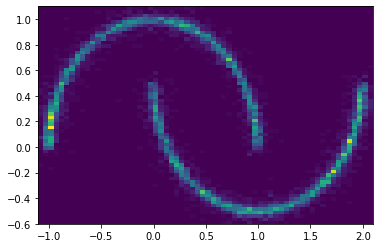

In [28]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

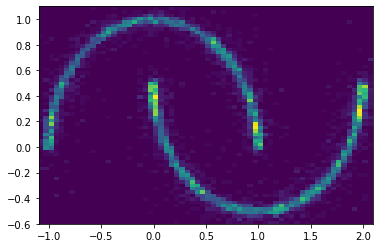

In [20]:
hist2d(samples[:,0,0],samples[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [32]:
dist_target=get_two_moons(sigmas[0]+0.02)

In [33]:
samps = dist_target.sample(10000, seed=jax.random.PRNGKey(0))

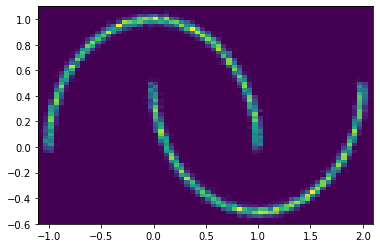

In [34]:
hist2d(samps[:,0],samps[:,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);

In [24]:
# And just to compare, what would have happened if we only ran a normal
# HMC in the same conditions
hmc = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=dist_target.log_prob,
    num_leapfrog_steps=3,
    step_size=0.0125)

In [25]:
samples_hmc, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=np.zeros([1,2]),
      kernel=hmc,
      trace_fn=lambda _, pkr: pkr.is_accepted, 
      seed=jax.random.PRNGKey(0))

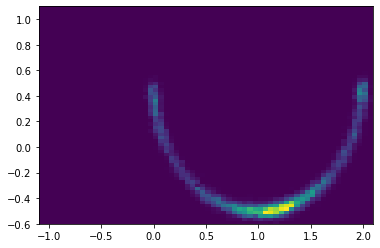

In [26]:
hist2d(samples_hmc[:,0,0],samples_hmc[:,0,1],64,
       range=[[-1.1,2.1],[-0.6,1.1]],);